CHOOSE IMAGE TO PREDICT

In [44]:
idx = 296

Library and paths

In [45]:
import torch
from monai.visualize import CAM
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt 
import os

# global settings
base_path = '/mnt/data_lab513/vqtran_data'
root_data = os.path.join(base_path, "data", "raw_data", "ADNI_NIfTI")
root_bias_correction = os.path.join(base_path, "data", "clean_data", "mri_bias_correction")
root_bet = os.path.join(base_path, "data", "clean_data", "mri_brain_extraction")
root_reg = os.path.join(base_path, "data", "clean_data", "mri_registration")
root_meta = os.path.join(base_path, "data", "meta_data")#, "Pre-Thesis_metadata", "ADNI") 
root_train = os.path.join(base_path, "data", "train_data")

Dataframe to manage dataset statistics

In [46]:
import pandas as pd
DATAFRAME_DIR = "./investigate/positive_inter_class_distance_sorted_dataframe_CN_EMCI_AD.csv"
dataset_csv = pd.read_csv(DATAFRAME_DIR)
dataset_csv.head()

,Subject ID,Image ID,Image Path,Image Target,DISTANCE CN,DISTANCE EMCI,DISTANCE AD,INTRA_CLASS_DISTANCE,INTER_CLASS_DISTANCE_CN_EMCI,INTER_CLASS_DISTANCE_CN_AD,INTER_CLASS_DISTANCE_EMCI_AD
0,062_S_1099,I30171,/mnt/data_lab513/vqtran_data/data/data_train_d...,CN,0.008518,0.015217,0.009556,0.008518,0.006699,0.001038,0.007737
1,005_S_0602,I17681,/mnt/data_lab513/vqtran_data/data/data_train_d...,CN,0.008672,0.015349,0.009723,0.008672,0.006677,0.001050,0.007727
2,051_S_1123,I33309,/mnt/data_lab513/vqtran_data/data/data_train_d...,CN,0.008669,0.015305,0.009691,0.008669,0.006636,0.001022,0.007658
3,011_S_0021,I7679,/mnt/data_lab513/vqtran_data/data/data_train_d...,CN,0.008052,0.014634,0.009088,0.008052,0.006582,0.001035,0.007617
4,133_S_0488,I14838,/mnt/data_lab513/vqtran_data/data/data_train_d...,CN,0.008088,0.014588,0.009147,0.008088,0.006501,0.001059,0.007560


In [47]:
# class distribution
dataset_csv["Image Target"].value_counts()

CN      100
EMCI    100
AD      100
Name: Image Target, dtype: int64

Draw sample image

In [48]:
# Take 42 as a random subject
image_path = dataset_csv["Image Path"][idx]
image_label = dataset_csv["Image Target"][idx]

In [49]:
import nibabel as nib
sample_dir = dataset_csv["Image Path"][idx] 
sample_img = nib.load(sample_dir)
sample_img_data = sample_img.get_fdata()
print("Image dimension:", sample_img_data.shape) #(182, 218, 182)

sample_image_tensor = torch.Tensor(sample_img_data)
# print(sample_image_tensor.shape)
# print(sample_image_tensor.dtype)

Image dimension: (182, 218, 182)


Image path: /mnt/data_lab513/vqtran_data/data/data_train_dec/unique/ADNI_003_S_1059_MR_MPRAGE_br_raw_20061110095115953_98_S22301_I29252.nii.gz
Image label: AD


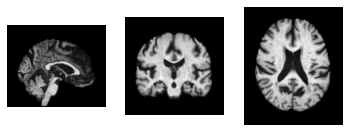

In [50]:
import matplotlib.pyplot as plt

def show_slices(slices, color = "gray"):
    """ Function to display row of image slices """
    # plt.figure()
    fig, axes = plt.subplots(1, len(slices))
    
    if color == "gray" or color == "hot" or color == "summer" or color == "jet":
        for i, slice in enumerate(slices):
            plt.axis('off')
            axes[i].imshow(slice.T, cmap=color, origin="lower")
            axes[i].axis('off')
    else: 
        raise Exception("choose gray, hot, summer, or jet for color")
    
    # plt.suptitle(f"Subject number: {idx}, label: {image_label}", verticalalignment = "bottom")
         
def create_and_show_slices(data_volume, color):
    if (len(data_volume.shape) == 4):
        print(data_volume.shape)
        img_data = torch.squeeze(data_volume,0)
    else:
        img_data = data_volume
        
    slice_0 = img_data[img_data.shape[0]//2, :, :]
    slice_1 = img_data[:, img_data.shape[1]//2, :]
    slice_2 = img_data[:, :, img_data.shape[2]//2]
    
    show_slices([slice_0, slice_1, slice_2], color)
    # plt.suptitle("Center slices for EPI image")  

create_and_show_slices(sample_image_tensor, "gray")
print("Image path:", dataset_csv["Image Path"][idx])
print("Image label:", dataset_csv["Image Target"][idx])

Prediction

In [51]:
from predict import predict
import time

start_time = time.time()
my_predict, model = predict(dataset_csv["Image Path"][idx], dataset_csv["Image Target"][idx], have_root = True)
print("Prediction time takes: %s seconds" % (time.time() - start_time))

print(my_predict)

load trained model from /mnt/data_lab513/vqtran_data/Model/models/trial_159.4/fold_3.pth
Prediction time takes: 1.9388763904571533 seconds
{'CN': 0.0008702734485268593, 'EMCI': 0.0001441381755284965, 'AD': 0.9989855885505676, 'label': 'AD', 'ground_truth': 'AD'}


Grad-CAM

In [52]:
image_tensor = torch.unsqueeze(sample_image_tensor,0)
# print(image_tensor.shape) #torch.Size([182, 218, 182])
# print(image_tensor.dtype) #torch.float32

image_transformation_tio_predict = tio.transforms.Compose(
    [
    tio.transforms.Resize((110,110,110)),
    tio.transforms.ZNormalization(),
    tio.RescaleIntensity(),
    ]
)

image = image_transformation_tio_predict(image_tensor)
image = torch.unsqueeze(image,0)
image.shape

torch.Size([1, 1, 110, 110, 110])

In [53]:
for name, _ in model.named_modules(): print(name)


module
module.model_resnet
module.model_resnet.base_model
module.model_resnet.base_model.conv1
module.model_resnet.base_model.bn1
module.model_resnet.base_model.relu
module.model_resnet.base_model.maxpool
module.model_resnet.base_model.layer1
module.model_resnet.base_model.layer1.0
module.model_resnet.base_model.layer1.0.conv1
module.model_resnet.base_model.layer1.0.bn1
module.model_resnet.base_model.layer1.0.relu
module.model_resnet.base_model.layer1.0.conv2
module.model_resnet.base_model.layer1.0.bn2
module.model_resnet.base_model.layer1.1
module.model_resnet.base_model.layer1.1.conv1
module.model_resnet.base_model.layer1.1.bn1
module.model_resnet.base_model.layer1.1.relu
module.model_resnet.base_model.layer1.1.conv2
module.model_resnet.base_model.layer1.1.bn2
module.model_resnet.base_model.layer1.2
module.model_resnet.base_model.layer1.2.conv1
module.model_resnet.base_model.layer1.2.bn1
module.model_resnet.base_model.layer1.2.relu
module.model_resnet.base_model.layer1.2.conv2
modul

In [54]:
import torch
from monai.visualize import CAM, GradCAM

cam = GradCAM(nn_module=model, target_layers="module.model_resnet.base_model.layer4.2.conv2")
mask = cam(x=image, class_idx=None, layer_idx = -1)

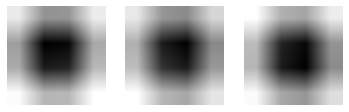

In [55]:
mask = mask.cpu()
mask = torch.squeeze(mask)
create_and_show_slices(mask, "gray")

In [56]:
import matplotlib.pyplot as plt

def show_slices_masks(slices, masks, color = "gray"):
    """ Function to display row of image slices """
    if (len(slices) != len(masks)):
        raise ValueError("Slides length and masks length are not equal")

    fig, axes = plt.subplots(1, len(slices))
    
    if color == "gray" or color == "hot" or color == "summer" or color == "jet":
        for i in range(len(slices)):
            plt.axis('off')
            axes[i].imshow(slices[i].T, cmap="gray", origin="lower")
            axes[i].imshow(masks[i].T, cmap=color, alpha=0.5 ,origin="lower")
            axes[i].axis('off')
    else: 
        raise Exception("choose gray, hot, summer, or jet for color")
         
def create_and_show_slices_with_masks(data_volume, mask_volume, color):
    if (len(data_volume.shape) == 4):
        print(data_volume.shape)
        img_data = torch.squeeze(data_volume,0)
    else:
        img_data = data_volume
        
    if (len(mask_volume.shape) == 4):
        print(mask_volume.shape)
        img_mask = torch.squeeze(mask_volume,0)
    else:
        img_mask = mask_volume
        
    slice_0 = img_data[img_data.shape[0]//2, :, :]
    slice_1 = img_data[:, img_data.shape[1]//2, :]
    slice_2 = img_data[:, :, img_data.shape[2]//2]
    
    mask_0 = 1- img_mask[img_mask.shape[0]//2, :, :]
    mask_1 = 1 - img_mask[:, img_mask.shape[1]//2, :]
    mask_2 = 1 - img_mask[:, :, img_mask.shape[2]//2]
    show_slices_masks([slice_0, slice_1, slice_2], [mask_0, mask_1, mask_2],color)
    # plt.suptitle("Center slices for EPI image")  

image_reverse_transform = tio.transforms.Compose(
    [
    tio.transforms.Resize((182,218,182)),
    ]
)

mask = torch.squeeze(mask)
mask= torch.unsqueeze(mask,0)
# print(mask.shape)
mask_resized = image_reverse_transform(mask)

image = torch.squeeze(image)
image = torch.unsqueeze(image,0)
# print(image.shape)
image_resized = image_reverse_transform(image)


GROUND TRUTH: AD
PREDICTION: {'CN': 0.0008702734485268593, 'EMCI': 0.0001441381755284965, 'AD': 0.9989855885505676, 'label': 'AD', 'ground_truth': 'AD'}
Original image:
Grad-CAM: 


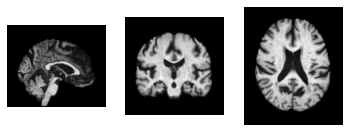

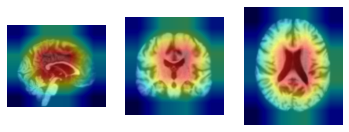

In [57]:
print("GROUND TRUTH:", image_label)
print("PREDICTION:", my_predict)
print("Original image:")
create_and_show_slices(sample_image_tensor, "gray")

print("Grad-CAM: ")
create_and_show_slices_with_masks(torch.squeeze(image_resized), torch.squeeze(mask_resized), "jet")
